In [355]:
# import modules
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [356]:
# Various useful functions

def get_mae(az_true, zen_true, az_pred, zen_pred): 
    """
    Given a predicted and true azimuth and zenith, compute the mae (mean angular error)
    """    
    if not (np.all(np.isfinite(az_true)) and
            np.all(np.isfinite(zen_true)) and
            np.all(np.isfinite(az_pred)) and
            np.all(np.isfinite(zen_pred))):
        raise ValueError("All arguments must be finite")
    
    # pre-compute all sine and cosine values
    sa1 = np.sin(az_true)
    ca1 = np.cos(az_true)
    sz1 = np.sin(zen_true)
    cz1 = np.cos(zen_true)
    
    sa2 = np.sin(az_pred)
    ca2 = np.cos(az_pred)
    sz2 = np.sin(zen_pred)
    cz2 = np.cos(zen_pred)
    
    # scalar product of the two cartesian vectors (x = sz*ca, y = sz*sa, z = cz)
    scalar_prod = sz1*sz2*(ca1*ca2 + sa1*sa2) + (cz1*cz2)
    
    # scalar product of two unit vectors is always between -1 and 1, this is against nummerical instability
    # that might otherwise occure from the finite precision of the sine and cosine functions
    scalar_prod =  np.clip(scalar_prod, -1, 1)
    
    # convert back to an angle (in radian)
    return np.average(np.abs(np.arccos(scalar_prod)))

def get_maes(y_pred, y_true): 
    """
    Given a list of predictions and true values of azimuth and zenith, compute mae
    """
    n = len(y_pred)
    maes = np.zeros(n)
    for i in range (0,n):
        az_true = y_true[i][0]
        ze_true = y_true[i][1]
        az_pred = y_pred[i][0]
        ze_pred = y_pred[i][1]
        mae = get_mae(az_true, ze_true, az_pred, ze_pred)
        maes[i] = mae
        
    return maes.mean()

In [357]:
# Read data
event_data = pd.read_csv("C:/Users/k_vsl/Documents/Erdos/Boot Camp/ice-cube-katja/all-feature.csv")

In [358]:
event_data.columns

Index(['Unnamed: 0', 'event_id', 'vx_t', 'vy_t', 'vz_t', 'az_t_pred',
       'ze_t_pred', 'mae_t', 'mse_squared', 'mse', 'vx_pca', 'vy_pca',
       'vz_pca', 'az_pca_pred', 'ze_pca_pred', 'az_true', 'ze_true',
       'num_clusters', 'dot_product'],
      dtype='object')

In [359]:
# Separate training parameters into features and output
X = event_data[['event_id', 'vx_t', 'vy_t', 'vz_t', 'az_t_pred',
       'ze_t_pred', 'mae_t', 'mse_squared', 'mse', 'vx_pca', 'vy_pca',
       'vz_pca', 'az_pca_pred', 'ze_pca_pred', 'num_clusters', 'dot_product']]
X = X.set_index("event_id")
y = event_data[['event_id', 'az_true', 'ze_true']]
y = y.set_index("event_id")

# Get categorical variable for mse
i = 0
mse_cat = np.zeros(len(X))
for row in X.itertuples(): 
    mse = row.mse
    if mse <= 721:
        mse_cat[i] = np.uint8(0)
    else:
        mse_cat[i] = np.uint8(1)
    i += 1
X['mse_cat'] = mse_cat

In [360]:
X.index.values

array([29296372, 29296374, 29296414, ..., 32567659, 32567680, 32567683],
      dtype=int64)

In [361]:
# Get categorical variable for num_clusters
W = pd.get_dummies(X['num_clusters'], prefix = 'cat')
W['event_id'] = X.index.values
W = W.set_index("event_id")
X = pd.merge(X, W, left_index = True, right_index = True)

In [362]:
X.columns

Index(['vx_t', 'vy_t', 'vz_t', 'az_t_pred', 'ze_t_pred', 'mae_t',
       'mse_squared', 'mse', 'vx_pca', 'vy_pca', 'vz_pca', 'az_pca_pred',
       'ze_pca_pred', 'num_clusters', 'dot_product', 'mse_cat', 'cat_1.0',
       'cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0',
       'cat_8.0', 'cat_9.0', 'cat_10.0', 'cat_11.0'],
      dtype='object')

In [363]:
X.head()

,vx_t,vy_t,vz_t,az_t_pred,ze_t_pred,mae_t,mse_squared,mse,vx_pca,vy_pca,...,cat_2.0,cat_3.0,cat_4.0,cat_5.0,cat_6.0,cat_7.0,cat_8.0,cat_9.0,cat_10.0,cat_11.0
event_id,,,,,,,,,,,,,,,,,,,,,
29296372,0.840768,0.133669,0.524635,0.157664,1.018510,2.595228,2.322060e+05,481.877540,0.950603,0.151131,...,0,0,0,0,0,0,0,0,0,0
29296374,0.211115,-0.119066,0.970182,5.769669,0.244814,0.045669,1.174334e+06,1083.666960,0.195457,-0.145903,...,0,0,1,0,0,0,0,0,0,0
29296414,-0.368366,-0.911470,-0.183109,4.328315,1.754944,1.128550,1.552522e+04,124.600239,-0.358119,-0.886117,...,0,0,0,0,0,0,0,0,0,0
29296416,0.539816,-0.666199,0.514566,5.393375,1.030295,2.349623,4.948033e+05,703.422549,0.629551,-0.776942,...,0,0,0,0,0,0,0,0,0,0
29296437,0.105650,-0.889777,0.443999,4.830573,1.110740,0.635174,4.716322e+06,2171.709365,0.007387,-0.906071,...,1,0,0,0,0,0,0,0,0,0


In [366]:
# Separate out a final training set
# random seed = 134
# test size = 25%
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                             shuffle = True,
                                                             random_state = 134, 
                                                             test_size = .25)

In [367]:
X_train.columns

Index(['vx_t', 'vy_t', 'vz_t', 'az_t_pred', 'ze_t_pred', 'mae_t',
       'mse_squared', 'mse', 'vx_pca', 'vy_pca', 'vz_pca', 'az_pca_pred',
       'ze_pca_pred', 'num_clusters', 'dot_product', 'mse_cat', 'cat_1.0',
       'cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0',
       'cat_8.0', 'cat_9.0', 'cat_10.0', 'cat_11.0'],
      dtype='object')

In [147]:
y_val.index.values

array([31755807, 31508861, 30795146, ..., 29735586, 30691628, 30091932],
      dtype=int64)

In [342]:
X_train.head()

,vx_t,vy_t,vz_t,az_t_pred,ze_t_pred,mae_t,mse_squared,mse,vx_pca,vy_pca,...,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0
event_id,,,,,,,,,,,,,,,,,,,,,
30454050,-4.118736e-01,-7.082578e-01,0.573351,4.185661,0.960207,0.109856,3.643922e+06,1908.905929,-0.423324,-6.828710e-01,...,1,0,0,0,0,0,0,0,0,0
30748024,-6.782162e-01,4.858384e-01,-0.551347,2.519979,2.154775,2.319469,2.841193e+05,533.028420,-0.378070,6.096823e-01,...,0,0,0,0,0,0,0,0,0,0
30755317,4.103319e-01,5.239152e-01,0.746419,0.906382,0.728132,2.444023,5.332882e+05,730.265872,0.387760,5.221182e-01,...,0,0,1,0,0,0,0,0,0,0
29988737,-9.556220e-15,-0.000000e+00,-1.000000,0.000000,3.141593,0.523975,9.692552e+03,98.450761,-0.000000,2.220446e-16,...,0,0,0,0,0,0,0,0,0,0
30774845,9.200957e-15,1.380144e-14,1.000000,0.000000,0.000000,2.605521,3.232729e+04,179.797920,0.000000,0.000000e+00,...,0,0,0,0,0,0,0,0,0,0


In [339]:
# k-fold cross validation
# this cell imitates the erdos lectures notes on kfold cross validation , k = 5
# random seed to all splits random_seed = 134
kfold = KFold(n_splits = 5,
             shuffle = True,
             random_state = 134)

In [340]:
# Model 1: No Linear Regression
# Just use the time best fit line and average the mae's from the line itself
mae_1 = np.zeros(5)
i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    X_holdout = X_train.iloc[test_index,:]
    mae = X_holdout.mae_t.values.mean()
    mae_1[i] = mae
    i += 1
    
mae_1

array([1.21090481, 1.2188864 , 1.21031589, 1.21663612, 1.21222924])

In [209]:
X_train.mse.values.max()

49428.35421677816

In [194]:
X_train.mae_t.values.mean()

1.2137944928512905

In [230]:
cutoffs = np.arange(720,740, 1)
n = len(cutoffs)
bad_mse = np.zeros(n)
good_mse = np.zeros(n)
for i in range(0,n): 
    cutoff = cutoffs[i]
    X_bad_mse = X_train[X_train.mse > cutoff]
    X_good_mse = X_train[X_train.mse < cutoff]
    bad_mse[i] = X_bad_mse.mae_t.values.mean()
    good_mse[i] = X_good_mse.mae_t.values.mean()

In [231]:
print(bad_mse)

[1.15743654 1.15730742 1.15738284 1.15734588 1.15736893 1.15738661
 1.1575534  1.15747106 1.15770708 1.15787748 1.15783986 1.15777789
 1.1579056  1.15777127 1.15794645 1.15790469 1.15787271 1.15779715
 1.15765075 1.15776601]


In [ ]:
# Best cutoff is 721

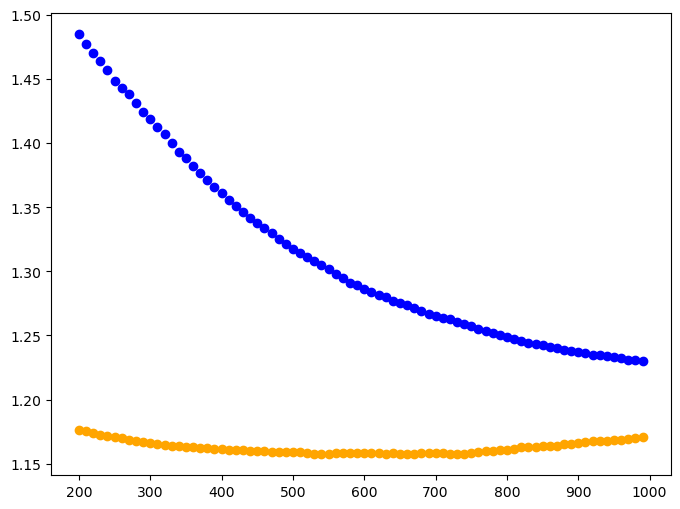

In [223]:
plt.figure(figsize=(8,6))

plt.scatter(cutoffs,
               bad_mse, 
           c = 'orange')
plt.scatter(cutoffs,
               good_mse, 
           c = 'blue')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [244]:
cutoffs = np.arange(.85,.99, .01)
n = len(cutoffs)
bad_dot = np.zeros(n)
good_dot = np.zeros(n)
for i in range(0,n): 
    cutoff = cutoffs[i]
    X_bad_dot = X_train[X_train.dot_product > cutoff]
    X_good_dot = X_train[X_train.dot_product < cutoff]
    bad_dot[i] = X_bad_dot.mae_t.values.mean()
    good_dot[i] = X_good_dot.mae_t.values.mean()

In [245]:
bad_dot

array([1.19177119, 1.19157143, 1.19131122, 1.19092452, 1.19055079,
       1.19010524, 1.18949486, 1.18910314, 1.18865289, 1.18817533,
       1.18803733, 1.1879714 , 1.1887497 , 1.18946705, 1.194869  ])

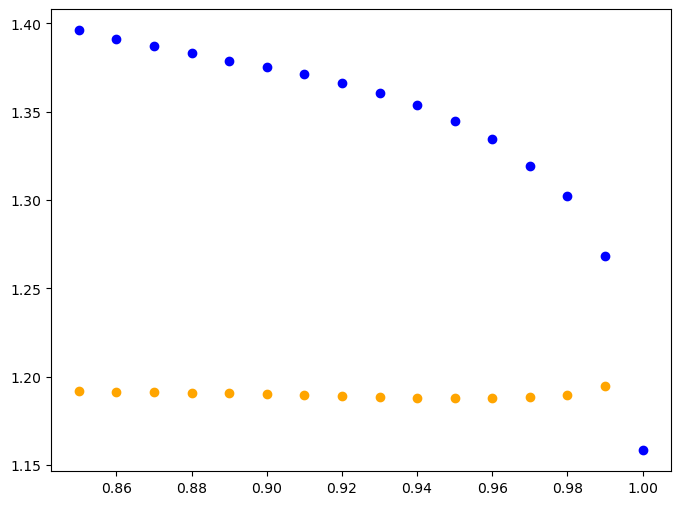

In [241]:
plt.figure(figsize=(8,6))

plt.scatter(cutoffs,
               bad_dot, 
           c = 'orange')
plt.scatter(cutoffs,
               good_dot, 
           c = 'blue')

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.show()

In [133]:
# Model 2: Linear regression on the az and ze predicted by the time best fit line
lr_2 = LinearRegression(copy_X = True)

X_train_2 = X_train[['az_t_pred', 'ze_t_pred']]
y_train_2 = y_train

mae_2 = np.zeros(5)
 
i = 0
for train_index, test_index in kfold.split(X_train_2, y_train_2):
    ## get the kfold training data
    X_train_train_2 = X_train_2.iloc[train_index,:]
    y_train_train_2 = y_train_2.iloc[train_index]
    
    ## get the holdout data
    X_holdout = X_train_2.iloc[test_index,:]
    y_holdout = y_train_2.iloc[test_index]
    
    lr_2.fit(X_train_train_2, y_train_train_2)
    y_pred = lr_2.predict(X_holdout)
    mae = get_maes(y_pred, y_holdout.values)   
    
    mae_2[i] = mae
    i += 1

print(mae_2)

[1.51719544 1.5142434  1.50928538 1.51007707 1.50063598]


In [134]:
# Model 3: Linear regression on the az and ze predicted by the time best fit line, in addition to clustering
lr_3 = LinearRegression(copy_X = True)
X_train_3 = X_train[['az_t_pred', 'ze_t_pred', 'num_clusters']]
y_train_3 = y_train

mae_3 = np.zeros(5)
 
i = 0
for train_index, test_index in kfold.split(X_train_3, y_train_3):
    ## get the kfold training data
    X_train_train_3 = X_train_3.iloc[train_index,:]
    y_train_train_3 = y_train_3.iloc[train_index]
    
    ## get the holdout data
    X_holdout = X_train_3.iloc[test_index,:]
    y_holdout = y_train_3.iloc[test_index]
    
    lr_3.fit(X_train_train_3, y_train_train_3)
    y_pred = lr_3.predict(X_holdout)
    mae = get_maes(y_pred, y_holdout.values)   
    
    mae_3[i] = mae
    i += 1

print(mae_3)

[1.51512107 1.51193854 1.50707891 1.50790698 1.49857972]


In [136]:
# Model 4: Linear regression on the az and ze predicted by the time best fit line, in addtion to the mse value
lr_4 = LinearRegression(copy_X = True)
X_train_4 = X_train[['az_t_pred', 'ze_t_pred', 'mse']]
y_train_4 = y_train

mae_4 = np.zeros(5)
 
i = 0
for train_index, test_index in kfold.split(X_train_2, y_train_2):
    ## get the kfold training data
    X_train_train_4 = X_train_4.iloc[train_index,:]
    y_train_train_4 = y_train_4.iloc[train_index]
    
    ## get the holdout data
    X_holdout = X_train_4.iloc[test_index,:]
    y_holdout = y_train_4.iloc[test_index]
    
    lr_4.fit(X_train_train_4, y_train_train_4)
    y_pred = lr_4.predict(X_holdout)
    mae = get_maes(y_pred, y_holdout.values)   
    
    mae_4[i] = mae
    i += 1

print(mae_4)

[1.51604937 1.51326716 1.507945   1.50884173 1.49960931]


In [138]:
# Model 5: Linear regression on the az and ze predicted by the time best fit line, in addtion to the dot product
lr_5 = LinearRegression(copy_X = True)
X_train_5 = X_train[['az_t_pred', 'ze_t_pred', 'dot_product']]
y_train_5 = y_train

mae_5 = np.zeros(5)
 
i = 0
for train_index, test_index in kfold.split(X_train_2, y_train_2):
    ## get the kfold training data
    X_train_train_5 = X_train_5.iloc[train_index,:]
    y_train_train_5 = y_train_5.iloc[train_index]
    
    ## get the holdout data
    X_holdout = X_train_5.iloc[test_index,:]
    y_holdout = y_train_5.iloc[test_index]
    
    lr_5.fit(X_train_train_5, y_train_train_5)
    y_pred = lr_5.predict(X_holdout)
    mae = get_maes(y_pred, y_holdout.values)   
    
    mae_5[i] = mae
    i += 1

print(mae_5)

[1.51574748 1.51241672 1.50761757 1.50851531 1.4990021 ]


In [139]:
# Model 6: Linear regression on the az and ze predicted by the time best fit line, in addition to the pca best fit line
lr_6 = LinearRegression(copy_X = True)
X_train_6 = X_train[['az_t_pred', 'ze_t_pred', 'az_pca_pred', 'ze_pca_pred']]
y_train_6 = y_train

mae_6 = np.zeros(5)
 
i = 0
for train_index, test_index in kfold.split(X_train_2, y_train_2):
    ## get the kfold training data
    X_train_train_6 = X_train_6.iloc[train_index,:]
    y_train_train_6 = y_train_6.iloc[train_index]
    
    ## get the holdout data
    X_holdout = X_train_6.iloc[test_index,:]
    y_holdout = y_train_6.iloc[test_index]
    
    lr_6.fit(X_train_train_6, y_train_train_6)
    y_pred = lr_6.predict(X_holdout)
    mae = get_maes(y_pred, y_holdout.values)   
    
    mae_6[i] = mae
    i += 1

print(mae_6)

[1.51637645 1.51318065 1.50831455 1.50938978 1.49994695]


In [297]:
# Model 7: Linear regression on the az and ze predicted by the time best fit line, in addtion to treating mse as categorical variable

# Get categorical variable
lr_7 = LinearRegression(copy_X = True)
X_train_7 = X_train[['az_t_pred', 'ze_t_pred', 'mse_cat']]
y_train_7 = y_train
 
i = 0
for train_index, test_index in kfold.split(X_train_7, y_train_7):
    ## get the kfold training data
    X_train_train_7 = X_train_7.iloc[train_index,:]
    y_train_train_7 = y_train_7.iloc[train_index]
    
    ## get the holdout data
    X_holdout = X_train_7.iloc[test_index,:]
    y_holdout = y_train_7.iloc[test_index]
    
    lr_7.fit(X_train_train_7, y_train_train_7)
    y_pred = lr_7.predict(X_holdout)
    mae = get_maes(y_pred, y_holdout.values)   
    mae_7[i] = mae
    i += 1

print(mae_7)

[1.50584927 1.50610422 1.51399367 1.50961388 1.51160511]


In [300]:
# Model 8: Just using linear regression on az and ze predicted by pca best fit line
lr_8 = LinearRegression(copy_X = True)

X_train_8 = X_train[['az_pca_pred', 'ze_pca_pred']]
y_train_8 = y_train

mae_8 = np.zeros(5)
 
i = 0
for train_index, test_index in kfold.split(X_train_2, y_train_2):
    ## get the kfold training data
    X_train_train_8 = X_train_8.iloc[train_index,:]
    y_train_train_8 = y_train_8.iloc[train_index]
    
    ## get the holdout data
    X_holdout = X_train_8.iloc[test_index,:]
    y_holdout = y_train_8.iloc[test_index]
    
    lr_8.fit(X_train_train_8, y_train_train_8)
    y_pred = lr_8.predict(X_holdout)
    mae = get_maes(y_pred, y_holdout.values)   
    
    mae_8[i] = mae
    i += 1

print(mae_8)

[1.52729618 1.52591641 1.51499511 1.52314813 1.52146113]


In [369]:
# Model 9: Using clustering as a categorical variable
lr_9 = LinearRegression(copy_X = True)

X_train_9 = X_train[['az_t_pred', 'ze_t_pred','cat_1.0',
       'cat_2.0', 'cat_3.0', 'cat_4.0', 'cat_5.0', 'cat_6.0', 'cat_7.0',
       'cat_8.0', 'cat_9.0', 'cat_10.0']]
y_train_9 = y_train

mae_9 = np.zeros(5)
 
i = 0
for train_index, test_index in kfold.split(X_train_2, y_train_2):
    ## get the kfold training data
    X_train_train_9 = X_train_9.iloc[train_index,:]
    y_train_train_9 = y_train_9.iloc[train_index]
    
    ## get the holdout data
    X_holdout = X_train_9.iloc[test_index,:]
    y_holdout = y_train_9.iloc[test_index]
    
    lr_9.fit(X_train_train_9, y_train_train_9)
    y_pred = lr_9.predict(X_holdout)
    mae = get_maes(y_pred, y_holdout.values)   
    
    mae_9[i] = mae
    i += 1

print(mae_9)

[1.51455969 1.51141769 1.50069706 1.51086064 1.50566327]
